
# Calculation average house property price in different Moscow districts depending on venues in a district 

## PART I:  <font size="4"> <b> Problem defenition and data preparation </b> </font>

<sup> *The capstone project of IBM Data Science Professional Certificate Specialization* </sup>


### Business problem defining

*Moscow (Russia) is in the top-20 cities with most expensive property prices in the world. Locals jokes that prices in Russia never decrease. They rise due to economic growth and even due to economic drawdown. Real-estate prices were rising during economic growth in Russia and peaked 6000 USD (or 150 000 RUB) per sq.meter on average in 2008. They were also rising in local currency due to inflation in Russia recent years when market oil price fell.*


![](https://www.irn.ru/graph/services/classes2.php?class=all&type=1&period=0&step=mon&grnum=1&currency=1)
<div style="text-align:center"> <sup><b>image:</b> house property price index (USD/sq meter from 2000 year)</sup></div>
<div style="text-align:center"> <sup><b>source:</b> www.irn.ru</sup></div>
  
![](https://www.irn.ru/graph/services/classes2.php?class=all&type=1&period=0&step=mon&grnum=1&currency=0)
<div style="text-align:center"> <sup><b>image:</b> house property price index (RUB/sq meter from 2000 year)</sup></div>
<div style="text-align:center"> <sup><b>source:</b> www.irn.ru</sup></div>


*Within the project, I'd like to consider the following potential situation. Imagine a construction company is going to lanch a project of affordable housing not far away from Moscow and build new houses. So they need to estimate what the market price for their real-estate will be within the market. Let's assume they are going to build new houses in the town called Mytischi located in 22.9 km from Moscow city center. At the same time we have to use FourSquare API to solve the problem because FourSquare data using is must as it is discribed as main condition of capstone project (everything else is the student chooses).*

**Summing up we need to calculate the final consumer price in USD per sq.meter for house property in Mytischi town using FourSquare API**

### Data description to be used

- [.geojson file with polygons of each Moscow neighborhood submitted by **codeforamerica** on github](https://github.com/codeforamerica/click_that_hood/blob/master/public/data/moscow.geojson)
- [the full list of Moscow neighborhoods with it's administrative devision from **gis-lab**](http://gis-lab.info/qa/moscow-atd.html)
- [average price per sq. meter in each Moscow neighborhood from **realtor-pro**](https://www.realtor-pro.ru/stoimost-kvadratnogo-metra-zhilya-v-moskve-po-rayonam)
- Amount of venues of each [venue category from FourSquare](https://developer.foursquare.com/docs/resources/categories) located in radius of 1 km of each polygon's centroid belonged to specific Moscow neighborhood


### Code section:

Importing libraries

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from geopy.geocoders import Nominatim
import folium # map rendering library

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


import json
import requests # library to handle requests
import branca

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

from sklearn.tree import export_graphviz
from subprocess import check_call
from os import system

Defining a function we will use to calculatuin a centroid of each polygon

In [26]:
def centroid(vertexes):
     x_list = [vertex [0] for vertex in vertexes]
     y_list = [vertex [1] for vertex in vertexes]
     leng = len(vertexes)
     x = sum(x_list) / leng
     y = sum(y_list) / leng
     return(x, y)

Data from https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/moscow.geojson

In [2]:
moscow_geo=r'C:\Users\khani\moscow.geojson' # geojson file
with open(moscow_geo) as f:
    data = json.load(f)

Filling the main dataframe

In [28]:
raw_datalist=[]
for i in range(len(data['features'])):
    raw_datalist.append([data['features'][i]['properties']['name'], 
                       data['features'][i]['properties']['name_lat'],                                      
                       centroid(data['features'][i]['geometry']['coordinates'][0][0])[1],
                        centroid(data['features'][i]['geometry']['coordinates'][0][0])[0]])
df=pd.DataFrame(raw_datalist)
df.columns=['District name(ru)', 'District name(en)','Lat','Lng']
print('Number of districts =', df.shape[0])
df.head(3)

Number of districts = 125


District name(ru)   District name(en)        Lat        Lng
0    район Восточный    rajon Vostochnyj  55.814862  37.874472
1  Обручевский район  Obruchevskij rajon  55.660381  37.523142
2     район Свиблово      rajon Sviblovo  55.855174  37.644165

Getting the data about Moscow administrative devision. Table #3

In [29]:
msc_regions=pd.read_html('http://gis-lab.info/qa/moscow-atd.html')[3]

More information about administrative devision in Moscow you can find in wiki (https://en.wikipedia.org/wiki/Administrative_divisions_of_Moscow)

In [30]:
msc_regions = msc_regions.drop([0,4,5], axis=1)
msc_regions.columns = ['Districts', 'Okrugs', 'Type']
msc_regions = msc_regions.drop([0], axis=0).reset_index(drop=True)
msc_regions.head(3)

Districts Okrugs                 Type
0  Академический   ЮЗАО  Муниципальный округ
1   Алексеевский   СВАО  Муниципальный округ
2   Алтуфьевский   СВАО  Муниципальный округ

For table merging from different souces I created a new column called 'Districts' to use it as a key for each table

In [31]:
df['Districts']=df['District name(ru)'].str.replace('район', '').str.strip()
df.head(3)

District name(ru)   District name(en)        Lat        Lng    Districts
0    район Восточный    rajon Vostochnyj  55.814862  37.874472    Восточный
1  Обручевский район  Obruchevskij rajon  55.660381  37.523142  Обручевский
2     район Свиблово      rajon Sviblovo  55.855174  37.644165     Свиблово

Two tables merging to see administrative devisions called 'Okrugs'

In [32]:
df=df.merge(msc_regions, how='inner', on='Districts', copy=False)
print('Number of districts =', df.shape[0])
df.head(3)

Number of districts = 125


District name(ru)   District name(en)        Lat        Lng    Districts  \
0    район Восточный    rajon Vostochnyj  55.814862  37.874472    Восточный   
1  Обручевский район  Obruchevskij rajon  55.660381  37.523142  Обручевский   
2     район Свиблово      rajon Sviblovo  55.855174  37.644165     Свиблово   

  Okrugs                 Type  
0    ВАО  Муниципальный округ  
1   ЮЗАО  Муниципальный округ  
2   СВАО  Муниципальный округ

Calculating how many districts in different Okrugs to see whether everything is done well there

In [33]:
df['Okrugs_lbl'] = df['Okrugs'].astype("category").cat.codes
df['Okrugs_lbl'].value_counts()

4    17
7    16
3    16
0    16
1    13
9    12
8    12
6    10
5     8
2     5
Name: Okrugs_lbl, dtype: int64

Web scrapping of our third table to add price per sq. meter for each neighborhood:

In [34]:
Prices = pd.read_html('https://www.realtor-pro.ru/stoimost-kvadratnogo-metra-zhilya-v-moskve-po-rayonam')[0]
Prices.head(3)

Рейтинг районов и метро  по уровню цен на Сентябрь 2018 г. (www.irn.ru)  \
                                                                        №   
0                                                  1                        
1                                                  2                        
2                                                  3                        

  Unnamed: 1_level_0                                 Unnamed: 2_level_0  \
              Районы                                      Станции метро   
0        Китай-город  Китай-город, Кузнецкий мост, Лубянка, Охотный ...   
1          Остоженка                       Кропоткинская, Парк культуры   
2           Тверской        Маяковская, Пушкинская, Тверская, Чеховская   

  Unnamed: 3_level_0 Unnamed: 4_level_0  
         РУБ за кв.м        USD за кв.м  
0            399 539               5899  
1            392 360               5793  
2            350 029               5168

Data wrangling and preparation for merging with the main dataframe 

In [35]:
Prices.columns=Prices.columns.droplevel()
Prices=Prices.drop(['№', 'Станции метро', 'РУБ за кв.м'], axis=1)
Prices.columns=['Districts', 'USD per sq.meter']
Prices.head(3)

Districts  USD per sq.meter
0  Китай-город              5899
1    Остоженка              5793
2     Тверской              5168

In [36]:
Prices.tail(3)

Districts  USD per sq.meter
83                                       Южное Бутово              1727
84              Бирюлево Восточное, Бирюлево Западное              1641
85  Крюково, Матушкино, Савёлки, Силино, Старое Кр...              1486

Looks like in the table we have several neighborhoods separated by comma with the same prices (table is grouped by price) so we need to split it in a way each row reffers to one specific district and it's price

In [37]:
Prices = Prices.set_index(['USD per sq.meter']).stack().str.split(',', expand=True).stack().unstack(-2).reset_index(-1, drop=True).reset_index()
Prices['Districts']=Prices['Districts'].str.strip()
Prices.tail(3)

USD per sq.meter       Districts
126              1486         Савёлки
127              1486          Силино
128              1486  Старое Крюково

Preparing our main column-key 'Districts' for merging. Wrangling again...

In [38]:
Prices['Districts']=Prices['Districts'].str.replace('ё', 'е')
df['Districts']=df['Districts'].str.replace('ё', 'е')
Prices['Districts']=Prices['Districts'].str.lower()
df['Districts']=df['Districts'].str.lower()

Join it with main DF

In [39]:
df=df.merge(Prices, how='inner', on='Districts', copy=True)
print('Number of districts =', df.shape[0])
df.head(3)

Number of districts = 125


District name(ru)   District name(en)        Lat        Lng    Districts  \
0    район Восточный    rajon Vostochnyj  55.814862  37.874472    восточный   
1  Обручевский район  Obruchevskij rajon  55.660381  37.523142  обручевский   
2     район Свиблово      rajon Sviblovo  55.855174  37.644165     свиблово   

  Okrugs                 Type  Okrugs_lbl  USD per sq.meter  
0    ВАО  Муниципальный округ           0              1886  
1   ЮЗАО  Муниципальный округ           9              2982  
2   СВАО  Муниципальный округ           4              2558

Now it is time to collect data FourSqure using it's API. We're going to use amount of venues of each category in a neigborhood as features in our model in part 2. Here we should define credential for our API access but for known reason I've hided them for you. Sry

In [28]:
CLIENT_ID = '*' # your Foursquare ID
CLIENT_SECRET = '*' # your Foursquare Secret
VERSION = '20180604'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: *
CLIENT_SECRET:*


First, we should know how many and what kind of venue categories FourSquare has. So we make a query to get a response

In [11]:
url='https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION) 
response=requests.get(url).json()

It looks like Four square categories have tree structure. There are categories which has subcateries and some of them has subsubcategories etc.

In [12]:
len(response['response']['categories'])
print("There're "+ str(len(response['response']['categories'])) +" categories of 1st level (major categories)")

There're 10 categories of 1st level (major categories)


Enlisting all categories into 1 DataFrame

In [13]:
cats=[]
for cat in response['response']['categories']:
    for sub_cat in cat['categories']:
        if len(sub_cat['categories'])!=0:
            for sub_sub_cat in sub_cat['categories']:
                cats.append([sub_cat['name'], sub_sub_cat['name'], sub_sub_cat['id']])
        else:
            cats.append([cat['name'], sub_cat['name'], sub_cat['id']])
df_cats=pd.DataFrame(cats, columns=['Category', 'Subcategory', 'ID'])

In [44]:
print("There're "+ str(df_cats.shape[0]) +" categories in total)")

There're 772 categories in total)


Should be enough

In the next code cells there is an algoritm sending a search query to FourSqure about location and name of each venue in 1 kilimeter radius of a polygon centroid reffering to a neigborhood. 

With 456 categories and 125 neigborhoods we must send a query to FourSqure 96 500 times. It took from me more than 7 hours in total to fill my final dataframe I will work with.

Sometimes it returned error (because of the internet connection) so the cell was relunched several times to fill null cells.

In [45]:
FQ_df=[]

In [ ]:
for i in range(len(df['Districts'])):
            
            print(df.loc[i, 'Districts'])
            
            for each in range(len(df_cats)):
          
                venuetype_id = df_cats.loc[each, 'ID']
                venuetype_name = df_cats.loc[each, 'Subcategory']
                print(df_cats.loc[each, 'Category'], df_cats.loc[each, 'Subcategory'])
                
                if(np.isnan(df.loc[i, venuetype_name])): #uncomment to fill null values only (to restore the process after returning a error)

                    url='https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&intent={}&categoryId={}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, df.loc[i, 'Lat'], df.loc[i, 'Lng'], 'browse', venuetype_id, VERSION, 1000, 50)
                    fq_data=requests.get(url).json()
                
                    try:
                        df.loc[i, venuetype_name]=len(fq_data['response']['venues'])
                
                        for each in fq_data['response']['venues']:
              
                          print(i, {'cat_name':each['categories'][0]['name'], 'name':each['name']})
                
                          FQ_df.append([df.loc[i, 'Districts'], 
                                        venuetype_name,
                                        each['id'], 
                                        each['categories'][0]['name'], 
                                        each['name'], 
                                        each['location']['lat'], 
                                        each['location']['lng']])
                    except:    
                        df.loc[i, venuetype_name]=0
                else:
                    print(i, df.loc[i, 'Districts'], 'is already filled')                        

In [ ]:
df_venues=pd.DataFrame(FQ_df, columns=['Districts', 'Venue cat', 'Venue ID', 'Venue type', 'Venue name', 'Lat', 'Lng'])
df_venues.head(3)

Saving progress for part II

In [ ]:
df_venues.to_csv(r'venuedataset_1km.csv', encoding='utf-8-sig')
df.to_csv(r'dataset_main_1km.csv', encoding='utf-8-sig')

## PART II:  <font size="4"> <b> Modeling, Evaluation, Results </b> </font>

In [7]:
df=pd.read_table(r'dataset_main_1km.csv', sep=',').drop(columns='Unnamed: 0')
df_venues=pd.read_table(r'venuedataset_1km.csv', sep=',').drop(columns='Unnamed: 0').drop_duplicates()

In [19]:
print(df.shape)
print(df_venues.shape)

(125, 781)
(156586, 7)


Now lets see what we have by creating a map of Moscow to see all scope of work. We are going to define each Okrug with specific color for better understanding further in which Okrug prices are higher

Firstly Lets' know coordinates of Moscow using Nominatim

In [3]:
Moscow = 'Moscow'
geolocator = Nominatim()
msc_location = geolocator.geocode(Moscow)
msc_latitude = msc_location.latitude
msc_longitude = msc_location.longitude

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  


And define coordinates where our new house will be built

In [4]:
Mytischi_Lat=55.914603
Mytischi_Lng=37.731570

In [21]:

moscow_map = folium.Map(location=[msc_latitude, msc_longitude], zoom_start=9,tiles='OpenStreetMap')

polygonstyle_function = lambda feature: dict(opacity=0.0, fill_opacity=0.0, line_opacity=0.0)

x = np.arange(df['Okrugs_lbl'].nunique())
ys = [i+x+(i*x)**2 for i in range(df['Okrugs_lbl'].nunique())]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for i in range(len(data['features'])):


    moscow_map.choropleth(
        geo_data=data['features'][i]['geometry'],
        key_on='feature.properties',
        fill_color=rainbow[df.loc[i, 'Okrugs_lbl']-1], 
        fill_opacity=0.3, 
        line_opacity=0.4,
        legend_name='Moscow Districts')   
    
    geojson = folium.GeoJson(data['features'][i]['geometry'], style_function=polygonstyle_function)
    popup =folium.Popup('{} : {} / {}. Price per sq.meter = {} USD'.format(df.loc[i, 'Okrugs'], 
                                                               df.loc[i, 'District name(ru)'], 
                                                               df.loc[i, 'District name(en)'],
                                                               df.loc[i, 'USD per sq.meter']))
    popup.add_to(geojson)
    geojson.add_to(moscow_map)
    
#    folium.CircleMarker(
#        [df.loc[i, 'Lat'], df.loc[i, 'Lng']],
#        radius=3,
#        weight=0.5,
#        popup='{} : {} / {}. Price per sq.meter = {} USD'.format(df.loc[i, 'Okrugs'], 
#                                      df.loc[i, 'District name(ru)'], 
#                                      df.loc[i, 'District name(en)'],
#                                      df.loc[i, 'USD per sq.meter']),
#        color='black',
#        fill=True,
#        fill_color=rainbow[df.loc[i, 'Okrugs_lbl']-1],
#        fill_opacity=1).add_to(moscow_map)

folium.Marker([Mytischi_Lat, Mytischi_Lng],  icon=folium.Icon(color='red', icon='home'), popup='Мытищи / Mytischi. Targer neigborhood and 1 km radius').add_to(moscow_map)
folium.Circle([Mytischi_Lat, Mytischi_Lng], 1000, color='red').add_to(moscow_map)
    
moscow_map

In [26]:
moscow_map.save("mymap.html")

Now I do the same map with the same neighborhoods recolor them with gradient from red to green depending on housing price in USD/per sq. meter in each neighborhood

In [27]:
colormap = branca.colormap.LinearColormap(colors=['green', 'yellow', 'red'], 
                                          index=[min(df['USD per sq.meter']), 3000, max(df['USD per sq.meter'])],
                                          vmin=min(df['USD per sq.meter']),vmax=max(df['USD per sq.meter']))
colormap.caption = "The cost of housing in different parts of Moscow (USD per sq.meter)"
# create a plain world map
moscow_map = folium.Map(location=[msc_latitude, msc_longitude], zoom_start=9, tiles='OpenStreetMap')

polygonstyle_function = lambda feature: dict(opacity=0.0, fillColor='', fill_opacity=0.0, line_opacity=0.0)

for i in range(len(data['features'])):

    moscow_map.choropleth(
        geo_data=data['features'][i]['geometry'],
        key_on='feature.properties',
        fill_color=colormap(df.loc[i, 'USD per sq.meter']), 
        fill_opacity=0.4, 
        line_opacity=0.3
        )  

    geojson = folium.GeoJson(data['features'][i]['geometry'], style_function=polygonstyle_function)
    popup =folium.Popup('{} : {} / {}. Price per sq.meter = {} USD'.format(df.loc[i, 'Okrugs'], 
                                                               df.loc[i, 'District name(ru)'], 
                                                               df.loc[i, 'District name(en)'],
                                                               df.loc[i, 'USD per sq.meter']))
    popup.add_to(geojson)
    geojson.add_to(moscow_map)
    
#for i in range(len(df['Districts'])):
    
#    folium.CircleMarker(
#        [df.loc[i, 'Lat'], df.loc[i, 'Lng']],
#        radius=3,
#        weight=0.5,
#        popup='{} : {} / {}. Price per sq.meter = {} USD'.format(df.loc[i, 'Okrugs'], 
#                                      df.loc[i, 'District name(ru)'], 
#                                      df.loc[i, 'District name(en)'],
#                                      df.loc[i, 'USD per sq.meter']),
#        color='black',
#        fill=True,
#        fill_color=colormap(df.loc[i, 'USD per sq.meter']),
#        fill_opacity=1).add_to(moscow_map)
    
folium.Marker([Mytischi_Lat, Mytischi_Lng],  icon=folium.Icon(color='red', icon='home'), popup='Мытищи / Mytischi. Targer neigborhood and 1 km radius').add_to(moscow_map)
folium.Circle([Mytischi_Lat, Mytischi_Lng], 1000, color='red').add_to(moscow_map)
    

colormap.add_to(moscow_map)    
moscow_map

The prices in Moscow city center are higher (which is obvious of course). In in west parts and south-west parts of the city real-estate prices sugnificantly higher then in other parts. Unfortenatly our target neighborhood, Mytischi, is not a part of administrative devision of Moscow so we will not to able to use administrative devision of Moscow as a feature for our model.

Maps above provide also basic insights about the data we gathered and how it is constructed. In each polygon reffered to a specific district you may see a centroid. We get venues amount (up to 50) of 456 categories in 1 km radius around of each centroid.

To decide what model to use it is better to get basic insight of what features (venue categories) are mostly common for neigborhoods with expensive and cheap housing. For this purpose we group neigborhoods in three classes depending on prices

1. Red class -  Price per sq. meter more than 3500 USD
2. Yellow class - Price per sq. between 3500 USD and 2000 USD
3. Green class - Price per sq. meter below 2000 USD

In [24]:
df.loc[df['USD per sq.meter']>=3500, 'USD per sq.meter (range)']=1
df.loc[((df['USD per sq.meter']>=2000) & (df['USD per sq.meter']<3500)), 'USD per sq.meter (range)']=2
df.loc[df['USD per sq.meter']<2000, 'USD per sq.meter (range)']=3

df.loc[df['USD per sq.meter (range)']==1, 'colorcode']='red'
df.loc[df['USD per sq.meter (range)']==2, 'colorcode']='yellow'
df.loc[df['USD per sq.meter (range)']==3, 'colorcode']='lime'

And now vizualize our three classes of neighborhoods on the map to see how they are distributed

In [25]:
moscow_map = folium.Map(location=[msc_latitude, msc_longitude], zoom_start=9,tiles='OpenStreetMap')

polygonstyle_function = lambda feature: dict(opacity=0.0, fill_opacity=0.0, line_opacity=0.0)

for i in range(len(data['features'])):

    moscow_map.choropleth(
        geo_data=data['features'][i]['geometry'],
        key_on='feature.properties',
        fill_color=df.loc[i, 'colorcode'], 
        fill_opacity=0.3, 
        line_opacity=0.4,
        legend_name='Moscow Districts')   
    
    geojson = folium.GeoJson(data['features'][i]['geometry'], style_function=polygonstyle_function)
    popup =folium.Popup('{} : {} / {}. Price per sq.meter = {} USD'.format(df.loc[i, 'Okrugs'], 
                                                               df.loc[i, 'District name(ru)'], 
                                                               df.loc[i, 'District name(en)'],
                                                               df.loc[i, 'USD per sq.meter']))
    popup.add_to(geojson)
    geojson.add_to(moscow_map)

    
moscow_map

In next cell we group our data by our new classes calculating average amount of venues of each category within a class

In [26]:
df_grouped=df.loc[:, (df != 0).any(axis=0)].groupby('USD per sq.meter (range)').mean().iloc[:, 4:].transpose()
df_grouped['Total']=df_grouped[1]+df_grouped[2]+df_grouped[3]
df_grouped.sort_values(by='Total', ascending=True, inplace=True)
df_grouped=df_grouped[df_grouped['Total']>5]
df_grouped=df_grouped.drop(columns='Total')
df_grouped.columns=['Red class', 'Yellow class', 'Green class']

It is obvious that in city center there is more diversification of venue categories. 
To get an understanding of on which venue categories our neighboehood classes differ from each other we would vizualize only those type of venues which average amount in Most expensive class less then in two others

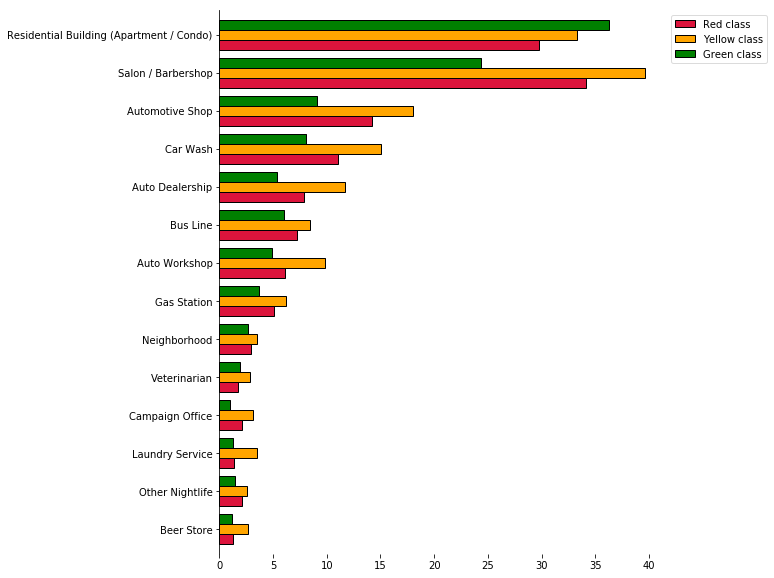

In [27]:
ax=df_grouped[(df_grouped['Red class']<df_grouped['Green class']) | (df_grouped['Red class']<df_grouped['Yellow class']) ].plot(kind='barh', figsize=(8, 10), color=['crimson', 'orange', 'green'], width =0.8, edgecolor = "black")
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)

legend_x = 1
legend_y = 1

plt.legend(bbox_to_anchor=(legend_x, legend_y)).get_frame().set_edgecolor('lightgray')

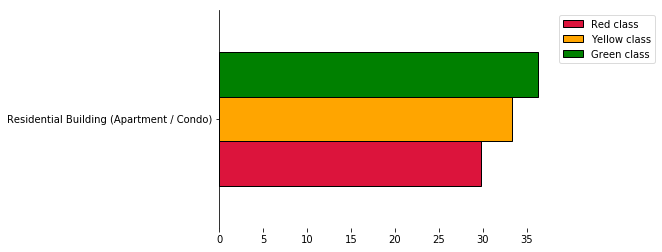

In [28]:
ax=df_grouped[(df_grouped['Yellow class']<df_grouped['Green class'])].plot(kind='barh', color=['crimson', 'orange', 'green'], width =0.8, edgecolor = "black")
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)

legend_x = 1
legend_y = 1

plt.legend(bbox_to_anchor=(legend_x, legend_y)).get_frame().set_edgecolor('lightgray')

Looks like living Buildings (condos) on average more frequent in green-priced neighborhoods. Lets make scatter plot to check if there is a liner relationship between Condos amount in a neigborhood and USD price per a condo sq. meter. We expect too see that with amont  of living buildings rising in a neigborhood, the price per sq.meter must decreasing

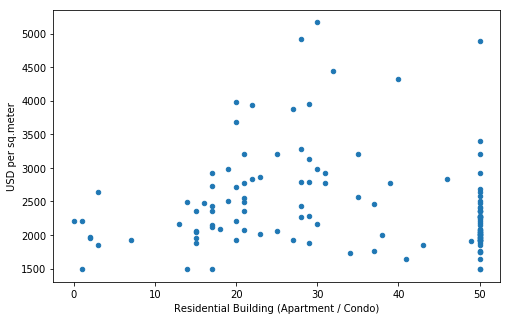

In [29]:
df.plot.scatter('Residential Building (Apartment / Condo)','USD per sq.meter', figsize=(8,5))

Nothing similar to what were expected. Moreover we can see that there is a cap in 50 of venues amount per category Foursquare provided for us, so hardly we can build a model based on classic regression. Morover usually new venues on foursquare are added by users so the data is very noisy and contains a lot of annacuracies. 

Summing the above we need an algorithm that can deal with big amount of features (high dimesionality) without overfitting. **Random Forest Regressor** can hadle this task easily since it drops unimportant features and we don't need realtime predictions.

Feature / target selection:

In [30]:
Xy=df.iloc[:, 8:-2]
y=Xy.iloc[:, 0]
X=Xy.iloc[:, 1:]

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(87, 772) (87,)
(38, 772) (38,)


Searching hyperparameters for our model:

In [33]:

n_estimators = [10,100,1000,5000,10000]
max_depth = [int(x) for x in np.linspace(2, 50, num = 10)]

param_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth}
print(param_grid)

{'n_estimators': [10, 100, 1000, 5000, 10000], 'max_depth': [2, 7, 12, 18, 23, 28, 34, 39, 44, 50]}


In [34]:
RF=RandomForestRegressor()

In [41]:

grid_search = GridSearchCV(estimator = RF, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)

grid_search.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  8.1min finished


{'max_depth': 23, 'n_estimators': 100}

Evaluating whether our found hyperparameters better then default parametars

In [42]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} USD'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

base_model = RandomForestRegressor()
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

Model Performance
Average Error: 279.2474 USD
Accuracy = 87.27%.


D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [43]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

Model Performance
Average Error: 247.2711 USD
Accuracy = 88.74%.


In [44]:
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Improvement of 1.69%.


Looks like there is an accuracy rise in comparison to default random forest parameters is not significant since Random Forest is the algorithm that works well even with default hypermarkets.

In [45]:
RF=RandomForestRegressor(n_estimators = 100, max_depth=23)
RF.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=23,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [46]:

importances = list(RF.feature_importances_)


feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(Xy.iloc[:,1:].columns, importances)]


feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)


for pair in feature_importances[:20]:
    print('Variable: {} / Importance: {}'.format(*pair)) 

Variable: Dry Cleaner / Importance: 0.1
Variable: Spa / Importance: 0.1
Variable: Doctor's Office / Importance: 0.05
Variable: Tourist Information Center / Importance: 0.05
Variable: Coworking Space / Importance: 0.04
Variable: Metro Station / Importance: 0.04
Variable: Design Studio / Importance: 0.03
Variable: Notary / Importance: 0.03
Variable: Tailor Shop / Importance: 0.03
Variable: General Travel / Importance: 0.03
Variable: Embassy / Consulate / Importance: 0.02
Variable: Language School / Importance: 0.02
Variable: Health & Beauty Service / Importance: 0.02
Variable: Bike Rental / Bike Share / Importance: 0.02
Variable: Theater / Importance: 0.01
Variable: Burger Joint / Importance: 0.01
Variable: Caucasian Restaurant / Importance: 0.01
Variable: Coffee Shop / Importance: 0.01
Variable: Gastropub / Importance: 0.01
Variable: Snack Place / Importance: 0.01


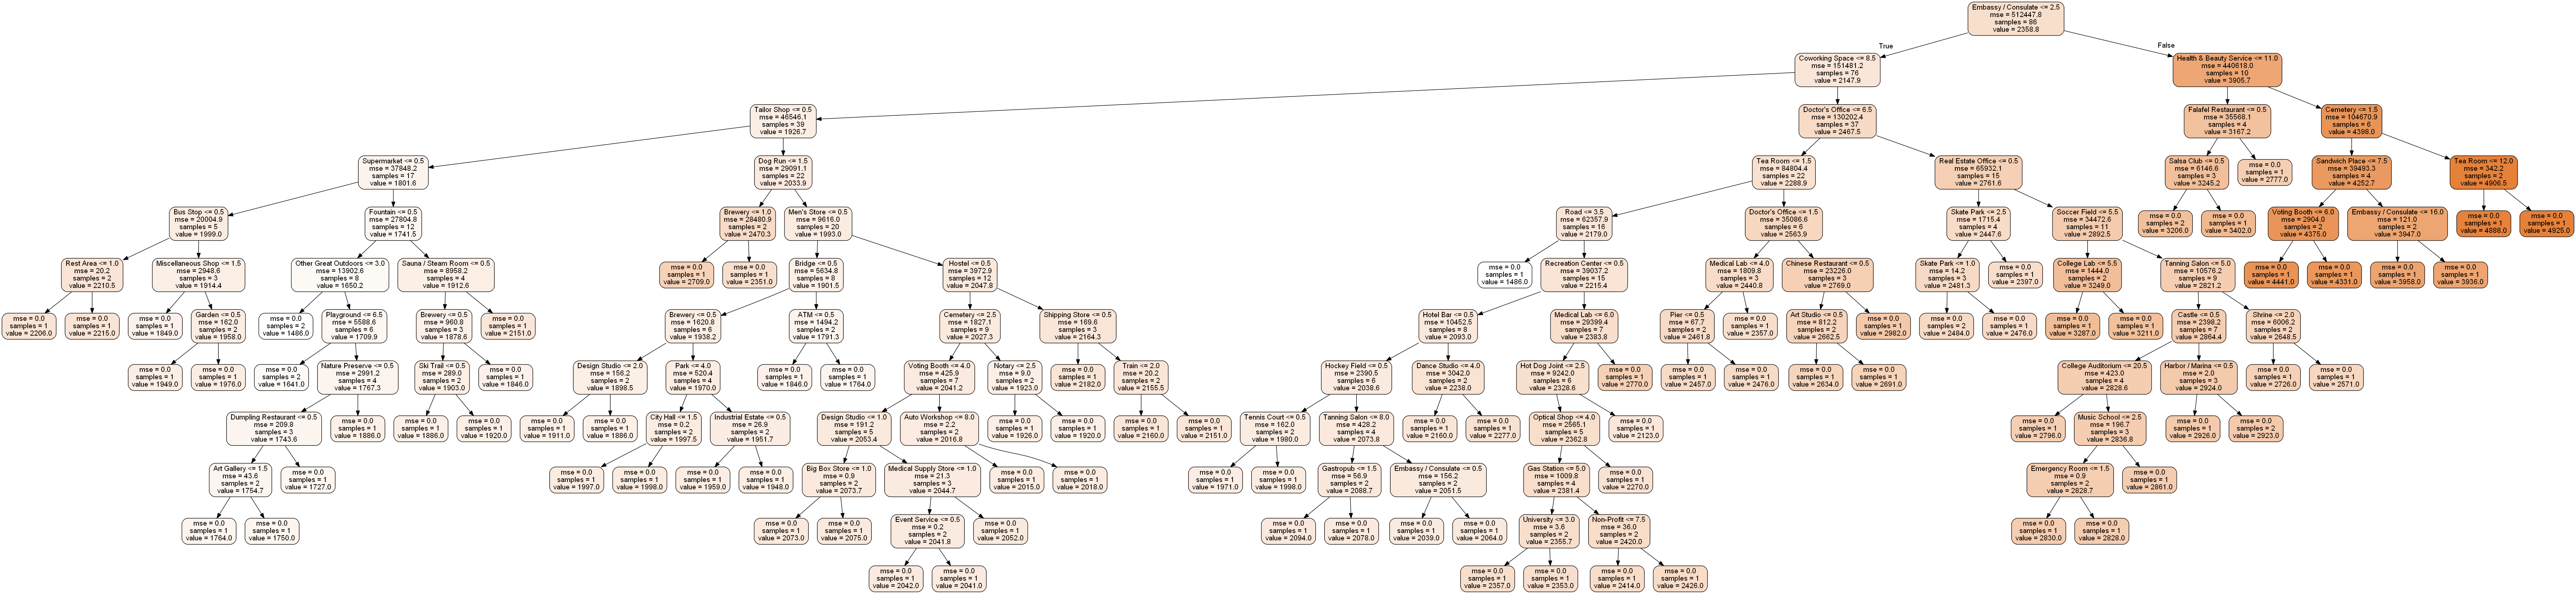

In [47]:


estimator = RF.estimators_[1]

with open(r"D:/dtree2.dot", 'w') as dotfile:

    export_graphviz(estimator, out_file=dotfile, 
                    feature_names = Xy.iloc[:,1:].columns,
                    rounded = True, proportion = False, 
                    precision = 1, filled = True)

system("dot -Tpng D:/dtree2.dot -o D:/dtree2.png")

# Display in jupyter notebook
from IPython.display import Image
Image(filename = "D:\dtree2.png")

So now with the model built we can now solve the business problem specified in the beggining of the project. To do that we should first get features we are going to predict on (venues amount in Mytischi neigborhood)

In [48]:
df.loc[125, 'Districts']='Mytischi'
df.loc[125, 'District name(ru)']='Мытищи'
df.loc[125, 'District name(en)']='Mytischi'
df.loc[125, 'Lat']=Mytischi_Lat
df.loc[125, 'Lng']=Mytischi_Lng
df.tail(1)

District name(ru) District name(en)        Lat       Lng Districts Okrugs  \
125            Мытищи          Mytischi  55.914603  37.73157  Mytischi    NaN   

    Type  Okrugs_lbl  USD per sq.meter  Amphitheater  Aquarium  Arcade  \
125  NaN         NaN               NaN           NaN       NaN     NaN   

     Art Gallery  Bowling Alley  Casino  Circus  Comedy Club  Concert Hall  \
125          NaN            NaN     NaN     NaN          NaN           NaN   

     Country Dance Club  Disc Golf  Exhibit  General Entertainment  \
125                 NaN        NaN      NaN                    NaN   

     Go Kart Track  Historic Site  Karaoke Box  Laser Tag  Memorial Site  \
125            NaN            NaN          NaN        NaN            NaN   

     Mini Golf  Drive-in Theater  Indie Movie Theater  Multiplex  Art Museum  \
125        NaN               NaN                  NaN        NaN         NaN   

     Erotic Museum  History Museum  Planetarium  Science Museum  Jazz Club  \
125            NaN             NaN          NaN             NaN        NaN   

     Piano Bar  Rock Club  Pachinko Parlor  Dance Studio  Indie Theater  \
125        NaN        NaN              NaN           NaN            NaN   

     Opera House  Theater  Pool Hall  Outdoor Sculpture  Street Art  \
125          NaN      NaN        NaN                NaN         NaN   

     Racecourse  Racetrack  Roller Rink  Salsa Club  Samba School  \
125         NaN        NaN          NaN         NaN           NaN   

     Baseball Stadium  Basketball Stadium  Cricket Ground  Football Stadium  \
125               NaN                 NaN             NaN               NaN   

     Hockey Arena  Rugby Stadium  Soccer Stadium  Tennis Stadium  \
125           NaN            NaN             NaN             NaN   

     Track Stadium  Theme Park Ride / Attraction  Tour Provider  Water Park  \
125            NaN                           NaN            NaN         NaN   

     Zoo Exhibit  College Arts Building  College Communications Building  \
125          NaN                    NaN                              NaN   

     College Engineering Building  College History Building  \
125                           NaN                       NaN   

     College Math Building  College Science Building  \
125                    NaN                       NaN   

     College Technology Building  College Administrative Building  \
125                          NaN                              NaN   

     College Auditorium  College Bookstore  College Cafeteria  \
125                 NaN                NaN                NaN   

     College Classroom  College Gym  College Lab  College Library  \
125                NaN          NaN          NaN              NaN   

     College Quad  College Rec Center  College Residence Hall  \
125           NaN                 NaN                     NaN   

     College Baseball Diamond  College Basketball Court  \
125                       NaN                       NaN   

     College Cricket Pitch  College Football Field  College Hockey Rink  \
125                    NaN                     NaN                  NaN   

     College Soccer Field  College Tennis Court  College Track  \
125                   NaN                   NaN            NaN   

     College Theater  Community College  Fraternity House  \
125              NaN                NaN               NaN   

     General College & University  Law School  Medical School  Sorority House  \
125                           NaN         NaN             NaN             NaN   

     Student Center  Trade School  University  Christmas Market  Conference  \
125             NaN           NaN         NaN               NaN         NaN   

     Convention  Festival  Line / Queue  Music Festival  Other Event  Parade  \
125         NaN       NaN           NaN             NaN          NaN     NaN   

     Sporting Event  Stoop Sale  Street Fair  Trade Fair  Afghan Restaurant  \
125           

In [49]:
for each in range(len(df_cats)):
          
    venuetype_id = df_cats.loc[each, 'ID']
    venuetype_name = df_cats.loc[each, 'Subcategory']
    print(df_cats.loc[each, 'Category'], df_cats.loc[each, 'Subcategory'])
                
    url='https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&intent={}&categoryId={}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, Mytischi_Lat, Mytischi_Lng, 'browse', venuetype_id, VERSION, 1000, 50)
    fq_data=requests.get(url).json()
                
    try:
        df.loc[125, venuetype_name]=len(fq_data['response']['venues'])
                
        for each in fq_data['response']['venues']:
              
            print(125, {'cat_name':each['categories'][0]['name'], 'name':each['name']})

    except:    
        df.loc[125, venuetype_name]=0


Arts & Entertainment Amphitheater
Arts & Entertainment Aquarium
Arts & Entertainment Arcade
125 {'cat_name': 'Arcade', 'name': 'Салон Головных Уборов Элис'}
125 {'cat_name': 'Arcade', 'name': 'Арт-центр "Ворк Студия"'}
125 {'cat_name': 'Arcade', 'name': 'AKVAREL DANCE'}
Arts & Entertainment Art Gallery
125 {'cat_name': 'Art Gallery', 'name': 'Мытищинская районная картинная галерея'}
Arts & Entertainment Bowling Alley
125 {'cat_name': 'Bowling Alley', 'name': 'Боулинг Пульсар'}
Arts & Entertainment Casino
Arts & Entertainment Circus
Arts & Entertainment Comedy Club
Arts & Entertainment Concert Hall
125 {'cat_name': 'Concert Hall', 'name': 'ДК «Яуза»'}
Arts & Entertainment Country Dance Club
Arts & Entertainment Disc Golf
Arts & Entertainment Exhibit
Arts & Entertainment General Entertainment
125 {'cat_name': 'General Entertainment', 'name': 'Новая Детская Площадка'}
125 {'cat_name': 'General Entertainment', 'name': 'Пирамида Спортивный Центр'}
125 {'cat_name': 'General Entertainment', '

Caribbean Restaurant Cuban Restaurant
Food Caucasian Restaurant
125 {'cat_name': 'Middle Eastern Restaurant', 'name': 'Хинкальная'}
Food Coffee Shop
125 {'cat_name': 'Coffee Shop', 'name': 'MyYummy'}
125 {'cat_name': 'Beer Store', 'name': 'Алко-профи и Кофе с собой'}
Food Comfort Food Restaurant
Food Creperie
Food Czech Restaurant
Food Deli / Bodega
125 {'cat_name': 'Deli / Bodega', 'name': 'Продуктовый магазин'}
125 {'cat_name': 'Deli / Bodega', 'name': 'Мясной Гастроном'}
Dessert Shop Cupcake Shop
125 {'cat_name': 'Cupcake Shop', 'name': 'Ягодное облако'}
Dessert Shop Frozen Yogurt Shop
Dessert Shop Ice Cream Shop
125 {'cat_name': 'Ice Cream Shop', 'name': 'Йогуртерия'}
Dessert Shop Pastry Shop
125 {'cat_name': 'Pastry Shop', 'name': 'Сдобная Выпечка "Каравай-Св"'}
Dessert Shop Pie Shop
Food Diner
Food Donut Shop
Food Dumpling Restaurant
Food Dutch Restaurant
Eastern European Restaurant Belarusian Restaurant
Eastern European Restaurant Bosnian Restaurant
Eastern European Restaurant B

125 {'cat_name': 'Beer Garden', 'name': '90 копеек'}
Bar Champagne Bar
Bar Cocktail Bar
125 {'cat_name': 'Cocktail Bar', 'name': 'PPH'}
125 {'cat_name': 'Cocktail Bar', 'name': 'Палата № 6'}
Bar Dive Bar
Bar Gay Bar
Bar Hookah Bar
125 {'cat_name': 'Lounge', 'name': 'Chilimi Lounge'}
125 {'cat_name': 'Hookah Bar', 'name': 'Мята Lounge'}
125 {'cat_name': 'Hookah Bar', 'name': "mr. Kal'yan Мытищи"}
125 {'cat_name': 'Hookah Bar', 'name': 'Hasta La Noche'}
125 {'cat_name': 'Hookah Bar', 'name': 'Mr.Kalyan'}
125 {'cat_name': 'Hookah Bar', 'name': 'Golden Smoke'}
Bar Hotel Bar
Bar Karaoke Bar
125 {'cat_name': 'Karaoke Bar', 'name': 'Кадриль'}
125 {'cat_name': 'Karaoke Bar', 'name': 'Varvara Bar'}
Bar Pub
Bar Sake Bar
Bar Speakeasy
Bar Sports Bar
125 {'cat_name': 'Sports Bar', 'name': 'Спорт-бар «Овертайм»'}
Bar Tiki Bar
Bar Whisky Bar
Bar Wine Bar
Nightlife Spot Brewery
125 {'cat_name': 'Brewery', 'name': 'Седьмой Литр'}
Nightlife Spot Lounge
125 {'cat_name': 'Lounge', 'name': 'Chilimi Lounge

States & Municipalities Village
125 {'cat_name': 'Village', 'name': 'пос. Жостово'}
Outdoors & Recreation Summer Camp
Outdoors & Recreation Trail
Outdoors & Recreation Tree
Outdoors & Recreation Vineyard
Outdoors & Recreation Volcano
Outdoors & Recreation Waterfall
Outdoors & Recreation Waterfront
Outdoors & Recreation Well
125 {'cat_name': 'Well', 'name': 'Артезианская вода "Калужская акватория"'}
Outdoors & Recreation Windmill
Professional & Other Places Animal Shelter
Professional & Other Places Art Studio
Professional & Other Places Auditorium
125 {'cat_name': 'Auditorium', 'name': 'Пресс-центр «Арена Мытищи»'}
Professional & Other Places Ballroom
Professional & Other Places Building
125 {'cat_name': 'Building', 'name': 'СДЭК'}
125 {'cat_name': 'Government Building', 'name': 'ЗАГС Мытищинский'}
125 {'cat_name': 'Building', 'name': 'ФГОУ «ГНМЦ» Минобороны России'}
125 {'cat_name': 'Building', 'name': 'Фонд социального страхования № 11'}
125 {'cat_name': 'Building', 'name': 'Пенсионн

125 {'cat_name': 'Parking', 'name': 'Стоянка'}
125 {'cat_name': 'Parking', 'name': 'Паркинг в "Гулливерах"'}
125 {'cat_name': 'Parking', 'name': 'Гаражный комплекс'}
125 {'cat_name': 'Parking', 'name': 'Стоянка'}
125 {'cat_name': 'Parking', 'name': 'ГК Ядреевские пруды'}
125 {'cat_name': 'Parking', 'name': 'Гараж'}
125 {'cat_name': 'Parking', 'name': 'Паркинг Атлант GYM'}
125 {'cat_name': 'Parking', 'name': 'Автостоянка'}
Professional & Other Places Post Office
125 {'cat_name': 'Post Office', 'name': 'Почта России 141008'}
125 {'cat_name': 'Post Office', 'name': 'Почта России 141002'}
Professional & Other Places Power Plant
Professional & Other Places Prison
Professional & Other Places Radio Station
125 {'cat_name': 'Radio Station', 'name': 'ТВ Мытищи'}
Professional & Other Places Recruiting Agency
Professional & Other Places Research Station
School Adult Education Center
125 {'cat_name': 'Adult Education Center', 'name': 'Мытищинская Школа Программистов'}
125 {'cat_name': 'Adult Educa

Shop & Service ATM
125 {'cat_name': 'ATM', 'name': 'Банкомат ВТБ24'}
Shop & Service Adult Boutique
Shop & Service Antique Shop
Shop & Service Arts & Crafts Store
125 {'cat_name': 'Arts & Crafts Store', 'name': 'Галантерея'}
Shop & Service Astrologer
Shop & Service Auto Dealership
125 {'cat_name': 'Auto Dealership', 'name': 'караффуто'}
125 {'cat_name': 'Auto Dealership', 'name': 'СТО КС-Авто'}
125 {'cat_name': 'Auto Dealership', 'name': 'Шиномонтаж'}
Shop & Service Auto Garage
Shop & Service Auto Workshop
125 {'cat_name': 'Auto Workshop', 'name': 'Студия автостайлинга "G7-studio"'}
Shop & Service Automotive Shop
125 {'cat_name': 'Automotive Shop', 'name': 'Автозапчасти 49'}
125 {'cat_name': 'Automotive Shop', 'name': 'Автосервис Амак-Авто'}
125 {'cat_name': 'Automotive Shop', 'name': 'Самый лучший автосервис'}
125 {'cat_name': 'Automotive Shop', 'name': 'autodoc.ru'}
125 {'cat_name': 'Automotive Shop', 'name': 'Автосервис'}
125 {'cat_name': 'Automotive Shop', 'name': 'автозапчасти'}
12

Food & Drink Shop Sausage Shop
Food & Drink Shop Street Food Gathering
Food & Drink Shop Supermarket
125 {'cat_name': 'Supermarket', 'name': 'Пятерочка'}
125 {'cat_name': 'Supermarket', 'name': 'Пятерочка'}
125 {'cat_name': 'Supermarket', 'name': 'Пятерочка'}
125 {'cat_name': 'Supermarket', 'name': 'Верный'}
125 {'cat_name': 'Supermarket', 'name': 'Магнит'}
125 {'cat_name': 'Supermarket', 'name': '«Верный»'}
125 {'cat_name': 'Supermarket', 'name': 'Пятерочка'}
125 {'cat_name': 'Supermarket', 'name': 'Пятерочка'}
125 {'cat_name': 'Supermarket', 'name': 'Универсам Магнит'}
125 {'cat_name': 'Supermarket', 'name': 'Перекресток'}
125 {'cat_name': 'Supermarket', 'name': 'Магазин Магнит'}
125 {'cat_name': 'Supermarket', 'name': 'Магнит'}
Food & Drink Shop Turşucu
Food & Drink Shop Wine Shop
125 {'cat_name': 'Wine Shop', 'name': 'Ароматный Мир'}
125 {'cat_name': 'Wine Shop', 'name': 'Отдохни'}
125 {'cat_name': 'Wine Shop', 'name': 'Лавина'}
125 {'cat_name': 'Wine Shop', 'name': 'Красное&Белое'

Shop & Service Shipping Store
Shop & Service Shoe Repair
Shop & Service Shopping Mall
125 {'cat_name': 'Shopping Mall', 'name': 'Торговый Комплекс Петра'}
125 {'cat_name': 'Shopping Mall', 'name': 'ТЦ Променад'}
125 {'cat_name': 'Shopping Mall', 'name': 'Ярмарка "Модный город"'}
Shop & Service Shopping Plaza
Shop & Service Skate Shop
Shop & Service Ski Shop
Shop & Service Smoke Shop
Shop & Service Smoothie Shop
Shop & Service Souvenir Shop
Shop & Service Spa
125 {'cat_name': 'Spa', 'name': 'Тайский Spa салон "Сиам"'}
Shop & Service Sporting Goods Shop
125 {'cat_name': 'Sporting Goods Shop', 'name': 'Спорт Товары'}
125 {'cat_name': 'Sporting Goods Shop', 'name': 'Синяя Линия'}
125 {'cat_name': 'Sporting Goods Shop', 'name': 'Ринг'}
125 {'cat_name': 'Sporting Goods Shop', 'name': 'Спартик'}
Shop & Service Stationery Store
Shop & Service Storage Facility
Shop & Service Supplement Shop
125 {'cat_name': 'Supplement Shop', 'name': 'Nl International'}
Shop & Service Tailor Shop
125 {'cat_name

Gathered the data needed we are ready to answer the final question

In [50]:
Mytischi_vector=df.iloc[125, 9:-2].values.reshape(1,-1)
RF.predict(Mytischi_vector)


array([2190.25])

### Answer:

**2190.USD is the price per sq. meter a building company may set for house property in Mytischi town.**